# Projekat - Predviđanje srčane bolesti

### Autor - Nenad Radović, RA18/2020

## Obrada podataka

### Osnovne informacije o podacima

Analizu podataka započinjemo otvaranjem fajla *heart.csv*

In [1]:
import pandas as pd

pd.set_option('display.max_columns', 21)

dataset = pd.read_csv(filepath_or_buffer='heart.csv')

Pogledajmo prvih nekoliko podataka

In [2]:
dataset.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


Izlistajmo metapodatke o podacima - broj podataka u svakoj koloni, vrste podataka,...

In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


Set podataka sadrži 10 *feature* kolona (*Age*, *Sex*, *ChestPainType*,...), kao i jedan *target* podatak (*HeartDisease*). Izlistajmo metapodatke o podacima u svakoj koloni - srednju vrijednost, standardnu devijaciju, minimalne i maksimalne vrijednosti,...

In [4]:
dataset.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


Kao što vidimo, u skupu se nalazi 918 podataka i ne postoje *null*, kao i *NaN* članovi u bilo kojoj od kolumni. Možemo primjetiti da neke minimalne i maksimalne vrijednosti dosta odskaču od srednje vrijednosti i njene okoline, te nam je to naznaka da neke kolone sadrže *anomalične* podatke.

### Pregled *target* kolone

Zadatak koji pred sobom imamo jeste predviđanje srčane bolesti kod pacijenata koristeći goreprikazane podatke. Očigledno je da je naša *target* kolona kolona *HeartDisease* koja se pravi na osnovu ustanovljenih bolesti pacijenata. Prikažimo na *pie chart*-u proporciju *HeartDisease* podataka.

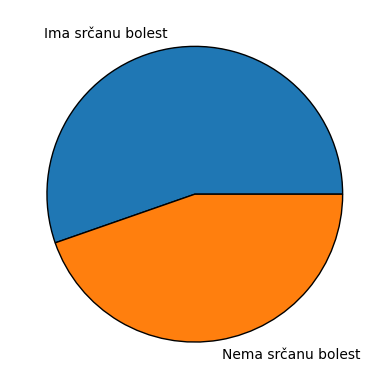

(508, 410)

In [5]:
pie = [dataset.loc[i]['HeartDisease'] for i in range(dataset.shape[0])]
pie_1 = 0
pie_0 = 0
for i in pie:
    if i:
        pie_1 += 1
    else:
        pie_0 += 1

from matplotlib import pyplot as plt

plt.pie([pie_1, pie_0], labels=['Ima srčanu bolest', 'Nema srčanu bolest'], wedgeprops={'edgecolor': 'black'})
plt.show()

pie_1, pie_0

Kao što vidimo, od 918 podataka postoji 410 pacijenata koji nemaju srčanu bolest, dok je kod 508 pacijenata dijagnostikovana srčana bolest. Procentualno, odnos je 45%:55% respektivno, te vidimo da imamo balansiranu *target* kolonu, što je veoma bitno za performanse i predviđanje modela.

### Anomalije u podacima

Pogledajmo odstupanja u vrijednostima kolona *RestingBP*, *Cholesterol*, *MaxHR* i *Oldpeak*. Svaku kolonu ćemo pretvoriti u novi *DataFrame* radi lakšeg rada sa njima.

In [6]:
# Kolone koje sadrže moguće anomalije
poss_anomalies = ['RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']

columndf = []
for pos_anomally in poss_anomalies:
    # Svakom elementu niza kolumni pridružujemo i naziv - koristiće kasnije
    columndf.append((pos_anomally, dataset[pos_anomally].to_frame()))

Anomalijama ćemo smatrati podatke koje su izvan 0.15% i 99.85% sveukupnih podataka. Za izdvajanje koristićemo *NumPy* biblioteku pomoću koje ćemo napraviti listu koja sadrži liste (od kojih svaka odgovara jednoj koloni) koje se sastoje od *False* i *True* vrijednosti, gdje *False* označava da je podatak unutar zadatog opsega, dok *True* označava da je izvan.

In [7]:
import numpy as np

percent99_vec = []; percent1_vec = []
for column in columndf:
    # Računanje tačaka koje su van opsega 0.15% - 99.85% 
    percent99 = column[1][column[1].keys()[0]] >= np.percentile(column[1][column[1].keys()[0]], 99.85, method='median_unbiased')
    percent1 = column[1][column[1].keys()[0]] <= np.percentile(column[1][column[1].keys()[0]], 0.15, method='median_unbiased')
    percent99_vec.append(percent99)
    percent1_vec.append(percent1)

Sada ćemo obojiti tačke radi grafičkog prikaza. Tačke su obojene u dvije boje - *plava* i *crvena*, gdje *plava* označava neanomaličnu vrijednost ("normalnu", onu koja upada u opseg) dok *crvena* označava anomaličnu.

In [8]:
i = 0
for column in columndf:
    # Bojenje tačaka
    column[1]['Color'] = np.where(percent99_vec[i], 'r', np.where(percent1_vec[i], 'r', 'b'))
    i += 1

Prikažimo grafički kako izgleda raspored podataka ove četiri kolone.

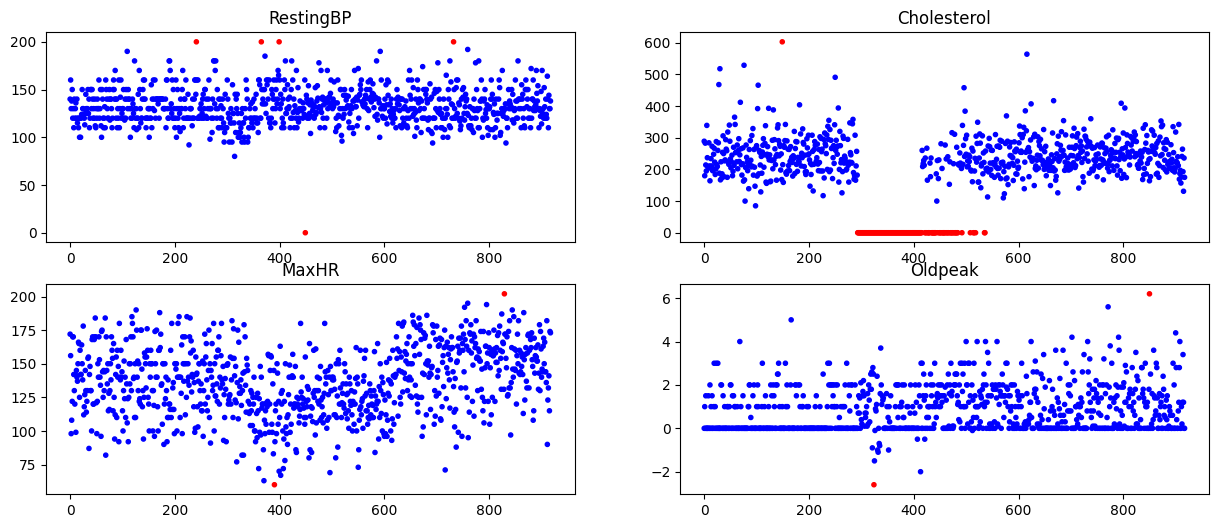

In [9]:
samples = np.arange(0, dataset.shape[0])
figure_before, axis_before = plt.subplots(2, 2, figsize=(15, 6))

i = 0
for j in range(0, 2):
    for k in range(0, 2):
        axis_before[j, k].scatter(samples, 
                                  columndf[i][1][columndf[i][1].keys()[0]], 
                                  marker='.', 
                                  c=list(columndf[i][1][columndf[i][1].keys()[1]]))
        axis_before[j, k].set_title(columndf[i][0])
        i+=1

Posmatrajmo gornja četiri grafika. Za svaki ponaosob zaključujemo da:
* Što se tiče *RestingBP* kolone, jedini pravi anomaličan podatak koji može ugroziti validnost modela jeste podatak čija je vrijednost 0, dok anomalije sa gornje granice nemaju toliko kritične vrijednosti (ne odskaču dosta od "regularnih vrijednosti").
* Što se tiče *Cholesterol* kolone, uklonićemo sve crvene tačke jer vidimo da dosta odskaču od regularnih vrijednosti.
* *MaxHR* kolona, kao i *Oldpeak* kolona imaju anomalične podatke koje ne odskaču mnogo od regularnih vrijednosti, te nije potrebno izbacivati takve podatke.

Dakle, izbacivaćemo samo podatke čije vrijednosti očevidno **mnogo** odstupaju od normalnih (regularnih) vrijednosti.

In [10]:
# Izbaci "donju" anomaliju u RestingBP koloni
index_rbp = [i for i in range(len(percent1_vec[0])) if percent1_vec[0][i]]

# Izbaci sve anomalične Cholesterol podatke
index_c = [i for i in range(len(percent99_vec[1])) if (percent1_vec[1][i] or percent99_vec[1][i])] 

to_drop = list(np.unique(index_rbp + index_c))
dataset.drop(labels=to_drop, inplace=True)
dataset.reset_index(drop=True, inplace=True)

Iscrtajmo još jednom grafike, ali ovaj put bez anomaličnih podataka

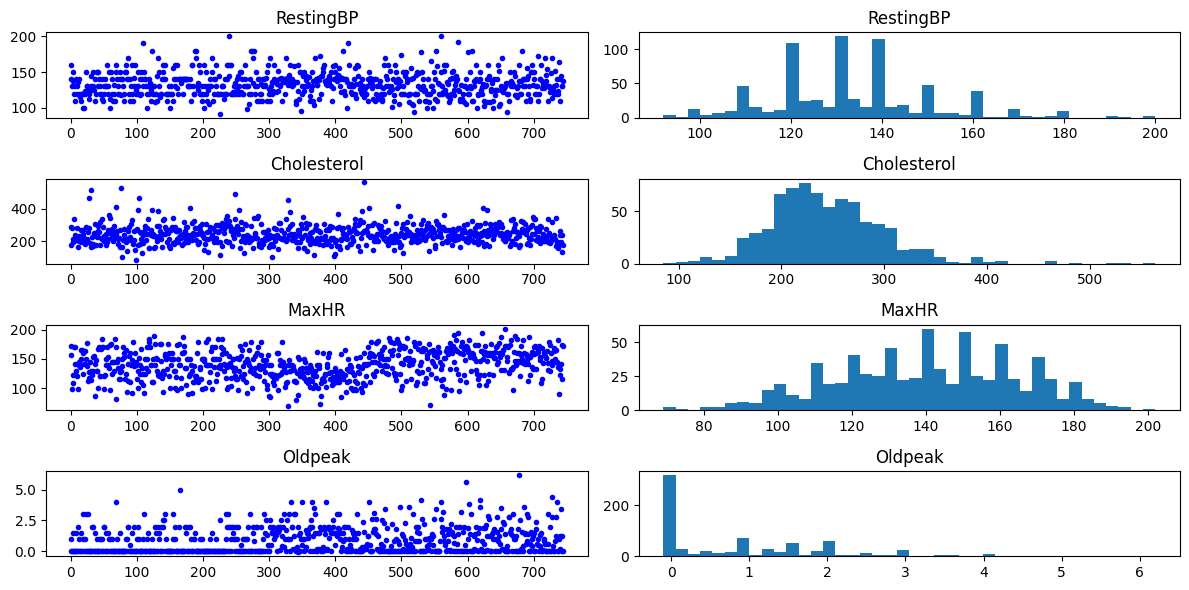

In [11]:
figure_after, axis_after = plt.subplots(4, 2, tight_layout=True, figsize=(12, 6))
samples = np.arange(0, dataset.shape[0])
i = 0
for j in range(0, 4):
    axis_after[j, 0].scatter(samples, 
                             dataset[poss_anomalies[i]], 
                             marker='.', 
                             c='b')
    axis_after[j, 1].hist(dataset[poss_anomalies[i]], bins=40)
    axis_after[j, 0].set_title(poss_anomalies[i])
    axis_after[j, 1].set_title(poss_anomalies[i])
    i+=1

### Enkodiranje podataka

Kako naš klasifikator može jedino raditi sa numeričkim vrijednostima, potrebno je karakterne vrijednosti "prevesti" u numeričke vrijednosti. *Enkodiranje* podataka vršićemo na takav način da ćemo izlistati sve moguće vrijednosti koje jedna kolona može imati i pomoću njih napraviti nove kolone, koje će sadržati 1 (*True*) na mjestu gdje podatak posjeduje tu vrijednost tog *feature*-a, kao i 0 (*False*) ako ne posjeduje - dakle, koristimo *One Hot* enkodiranje.

Još jedan problem na koji nailazimo jeste problem [*dummy variable zamke*](https://stats.stackexchange.com/questions/415841/which-ml-algorithms-are-affected-by-dummy-variable-trap). 
Za neke modele *dummy variable zamka* može pogoršati validnost, dok su neki modeli imuni na nju. Zato ostavljamo mogućnost izbora modela, te da li će biti uklonjena jedna varijabla pri enkodiranju.
* Ako je model logistička regresija, onda *drop_first* opcija pri ekodiranju mora biti postavljena na *True* vrijednost.
* Ako je model KNN ili stablo odluke, onda *drop_first* opcija može biti postavljena na *False* vrijednost.

Zato ćemo odmah napraviti i raditi sa dva *dataset*-a, jedan za logističku regresiju, dok drugi za modele KNN i stabla odluke.

In [12]:
to_encode = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']

dataset_lr = pd.get_dummies(dataset, columns=to_encode, drop_first=True)
dataset_kt = pd.get_dummies(dataset, columns=to_encode, drop_first=False)

Set podataka logističke regresije izgleda kao

In [13]:
dataset_lr.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up
0,40,140,289,0,172,0.0,0,True,True,False,False,True,False,False,False,True
1,49,160,180,0,156,1.0,1,False,False,True,False,True,False,False,True,False
2,37,130,283,0,98,0.0,0,True,True,False,False,False,True,False,False,True
3,48,138,214,0,108,1.5,1,False,False,False,False,True,False,True,True,False
4,54,150,195,0,122,0.0,0,True,False,True,False,True,False,False,False,True


Set podataka KNN i modela stabla odluke izgleda kao

In [14]:
dataset_kt.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_F,Sex_M,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina_N,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
0,40,140,289,0,172,0.0,0,False,True,False,True,False,False,False,True,False,True,False,False,False,True
1,49,160,180,0,156,1.0,1,True,False,False,False,True,False,False,True,False,True,False,False,True,False
2,37,130,283,0,98,0.0,0,False,True,False,True,False,False,False,False,True,True,False,False,False,True
3,48,138,214,0,108,1.5,1,True,False,True,False,False,False,False,True,False,False,True,False,True,False
4,54,150,195,0,122,0.0,0,False,True,False,False,True,False,False,True,False,True,False,False,False,True


Radi uljepšavanja izgleda tabele, izmjestićemo *target* kolonu *HeartDisease* na posljednje mjesto.

In [15]:
dataset_lr = dataset_lr[[column for column in dataset_lr.columns if column != 'HeartDisease'] + ['HeartDisease']]
dataset_kt = dataset_kt[[column for column in dataset_kt.columns if column != 'HeartDisease'] + ['HeartDisease']]

In [16]:
dataset_lr.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up,HeartDisease
0,40,140,289,0,172,0.0,True,True,False,False,True,False,False,False,True,0
1,49,160,180,0,156,1.0,False,False,True,False,True,False,False,True,False,1
2,37,130,283,0,98,0.0,True,True,False,False,False,True,False,False,True,0
3,48,138,214,0,108,1.5,False,False,False,False,True,False,True,True,False,1
4,54,150,195,0,122,0.0,True,False,True,False,True,False,False,False,True,0


In [17]:
dataset_kt.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,Sex_F,Sex_M,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina_N,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up,HeartDisease
0,40,140,289,0,172,0.0,False,True,False,True,False,False,False,True,False,True,False,False,False,True,0
1,49,160,180,0,156,1.0,True,False,False,False,True,False,False,True,False,True,False,False,True,False,1
2,37,130,283,0,98,0.0,False,True,False,True,False,False,False,False,True,True,False,False,False,True,0
3,48,138,214,0,108,1.5,True,False,True,False,False,False,False,True,False,False,True,False,True,False,1
4,54,150,195,0,122,0.0,False,True,False,False,True,False,False,True,False,True,False,False,False,True,0


### Normalizacija podataka

Kako naši podaci imaju različite skale vrijednosti (recimo, *Cholesterol* kolona može imati vrijednost 300, dok *OldPeak* samo 6), potrebno je normalizovati (skalirati, standardizovati) podatke kako bi model pridavao sličan značaj i uticaj svim podacima. Postoji nekoliko vrsta normalizacija (*MinMaxScaller*, *StandardScaler* i sl.), ali mi ćemo koristiti *RobustScaler*, koji se pokazao najboljim od ostalih.

Naravno, skaliramo numeričke podatke (čiji su nazivi kolona već sadržani u listi *poss_anomalies*, plus *Age* kolona).

Ovdje moramo napraviti **distinkciju** - *RobustScaler* može samo da se *fit*-uje na trening podatke - **naš model prije testiranja ne smije znati ništa o *test* podacima!** U tu svrhu, sada ćemo razdvojiti trening i testne podatke.

In [18]:
from sklearn.model_selection import train_test_split

X_lr = dataset_lr.drop(labels=['HeartDisease'], axis='columns')
y_lr = dataset_lr['HeartDisease']

X_kt = dataset_kt.drop(labels=['HeartDisease'], axis='columns')
y_kt = dataset_kt['HeartDisease']

X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(X_lr, y_lr, test_size=0.3, stratify=y_lr)
X_train_kt, X_test_kt, y_train_kt, y_test_kt = train_test_split(X_kt, y_kt, test_size=0.3, stratify=y_kt)

Sada, kada su podaci podijeljeni u trening i test skupove, skalirajmo, *fit*-ujmo i transformišimo trening skup, dok je potrebno samo da transformišemo test skup.

In [19]:
from sklearn.preprocessing import RobustScaler

to_scale = poss_anomalies
to_scale.append('Age')

scaler_lr = RobustScaler()
scaler_kt = RobustScaler()

X_train_lr[to_scale] = scaler_lr.fit_transform(X_train_lr[to_scale])
X_train_kt[to_scale] = scaler_kt.fit_transform(X_train_kt[to_scale])

X_test_lr[to_scale] = scaler_lr.transform(X_test_lr[to_scale])
X_test_kt[to_scale] = scaler_kt.transform(X_test_kt[to_scale])

Sada, podaci u trening skupu izgledaju kao

In [20]:
X_train_lr.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up
680,-0.500000,0.4,0.264706,0,0.444444,-0.333333,True,False,True,False,False,False,False,False,True
724,0.071429,-0.1,-0.500000,0,-0.277778,1.000000,False,False,False,False,False,True,True,True,False
368,1.571429,-1.3,-1.852941,0,-0.555556,2.000000,True,False,True,False,False,False,False,False,False
495,0.642857,0.5,-0.647059,0,1.083333,-0.333333,False,True,False,False,True,False,False,False,True
447,0.785714,-0.5,-0.911765,0,0.000000,-0.066667,True,False,False,False,True,False,False,False,True


In [21]:
X_train_kt.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,Sex_F,Sex_M,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina_N,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
689,0.785714,1.25,0.492537,0,0.210526,0.1875,True,False,False,False,True,False,False,True,False,True,False,False,False,True
28,-0.071429,-0.85,3.462687,0,-0.342105,-0.3125,True,False,False,True,False,False,False,True,False,True,False,False,False,True
211,0.142857,0.00,0.597015,0,-0.315789,0.3125,False,True,False,False,True,False,False,True,False,False,True,False,False,True
473,0.857143,1.50,-0.119403,0,-0.052632,1.1250,False,True,True,False,False,False,True,False,False,True,False,False,False,True
538,0.857143,-0.50,0.985075,0,0.289474,-0.0625,False,True,True,False,False,False,True,False,False,True,False,False,True,False


### Korelacija između podataka

Ako želimo smanjiti dimenzionalnost problema, možemo pokušati pronaći koliko su *feature*-i međusobno korelirani. Dakle, ako uspijemo naći jak odnos između dva *feature*-a, onda možemo izvesti iz razmatranja jedan od njih upravo zato jer se "isto" ponašaju (kada vrijednost jednog *feature*-a kontinualno raste, tada vrijedosti drugog *feature*-a takođe rastu ili opadaju monotonski).

Za određivanje jačine korelacije koristićemo *Spearmanov koeficijent korelacije*, koji predstavlja u kojoj mjeri između dvije promjenljive (dva *feature*-a) postoji monotonski odnos (ako se jedna povećava i druga se povećava i sl.). Njegove vrijedosti se kreću od *-1* (koja označava *negativnu* koreliranost, odnosno slučaj da ako jedna promjenljiva *raste*/*opada*, druga se ponaša suprotno - *opada*/*raste* i obratno) do *1* (koja označava *pozitivnu* koreliranost, odnosno slučaj da ako jedna promjenljiva *raste*/*opada*, druga takođe *raste*/*opada* i obratno). Koeficijent od *0* označava nikakvu monotonu koreliranost.

Spearmanov koeficijent govori da su varijable **snažno** korelirane ako ima vrijednost iznad 0.6, dok su **slabo** korelirane ako je koeficijent ispod 0.2.

Korisno bi bilo prikazati korelaciju između svih *feature*-a i *target* podataka.

Kada je u pitanju **logistička regresija**:

<Axes: >

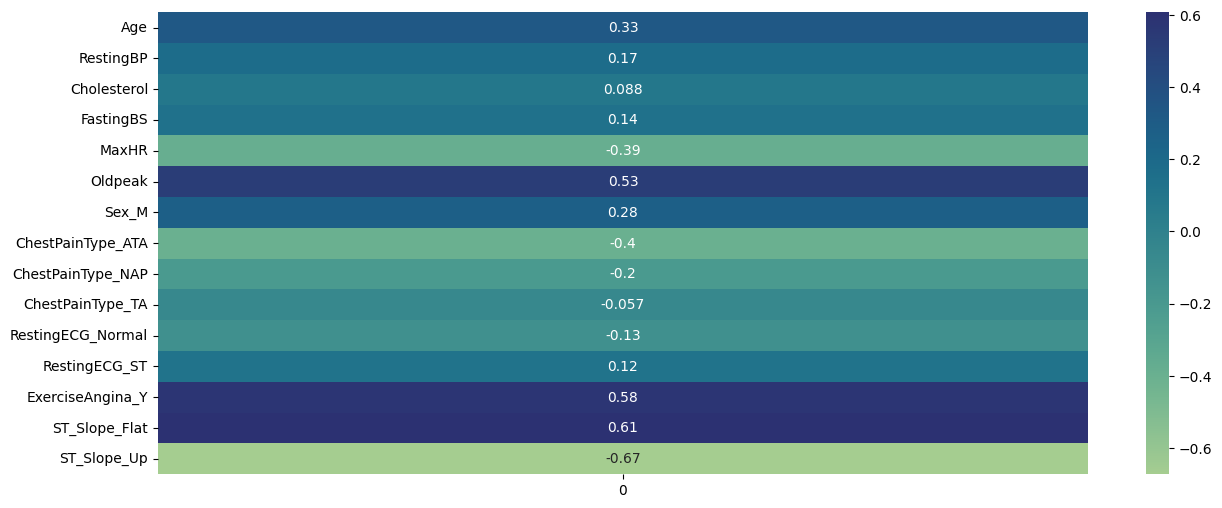

In [22]:
import seaborn as sns

figure_corr_ft_lr, axis_corr_ft_lr = plt.subplots(figsize=(15, 6))
corr_ft_lr = pd.DataFrame(X_train_lr.corrwith(y_train_lr, method='spearman'))
sns.heatmap(corr_ft_lr, annot=True, cmap='crest')

Kada je u pitanju **KNN** i **model stabla odluke**:

<Axes: >

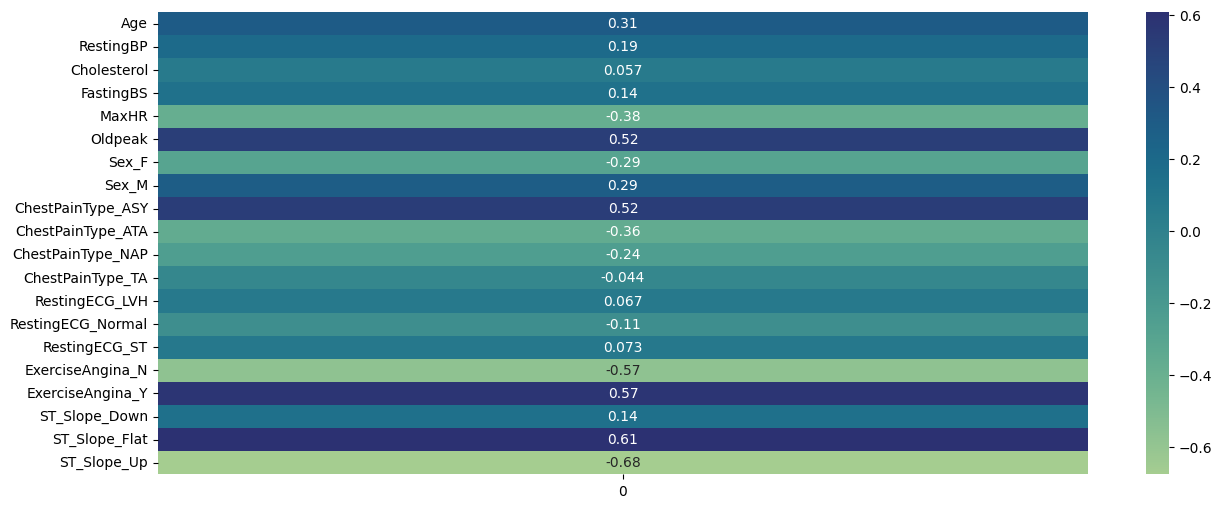

In [23]:
figure_corr_ft_kt, axis_corr_ft_kt = plt.subplots(figsize=(15, 6))
corr_ft_kt = pd.DataFrame(X_train_kt.corrwith(y_train_kt, method='spearman'))
sns.heatmap(corr_ft_kt, annot=True, cmap='crest')

Provjerimo koje kolone bismo uklonili ako bi samo posmatrali korelaciju sa *target* skupom.

Kada je u pitanju **logistička regresija**:

In [24]:
corr_ft_lr = corr_ft_lr.abs()
to_drop_ft_lr = [i for i in corr_ft_lr.index if corr_ft_lr[0][i] < 0.2]
to_drop_ft_lr

['RestingBP',
 'Cholesterol',
 'FastingBS',
 'ChestPainType_TA',
 'RestingECG_Normal',
 'RestingECG_ST']

Kada je u pitanju **KNN** i **model stabla odluke**:

In [25]:
corr_ft_kt = corr_ft_kt.abs()
to_drop_ft_kt = [i for i in corr_ft_kt.index if corr_ft_kt[0][i] < 0.2]
to_drop_ft_kt

['RestingBP',
 'Cholesterol',
 'FastingBS',
 'ChestPainType_TA',
 'RestingECG_LVH',
 'RestingECG_Normal',
 'RestingECG_ST',
 'ST_Slope_Down']

Sada, provjerimo kako su *feature*-i međusobno korelirani.

Kada je u pitanju **logistička regresija**:

<Axes: >

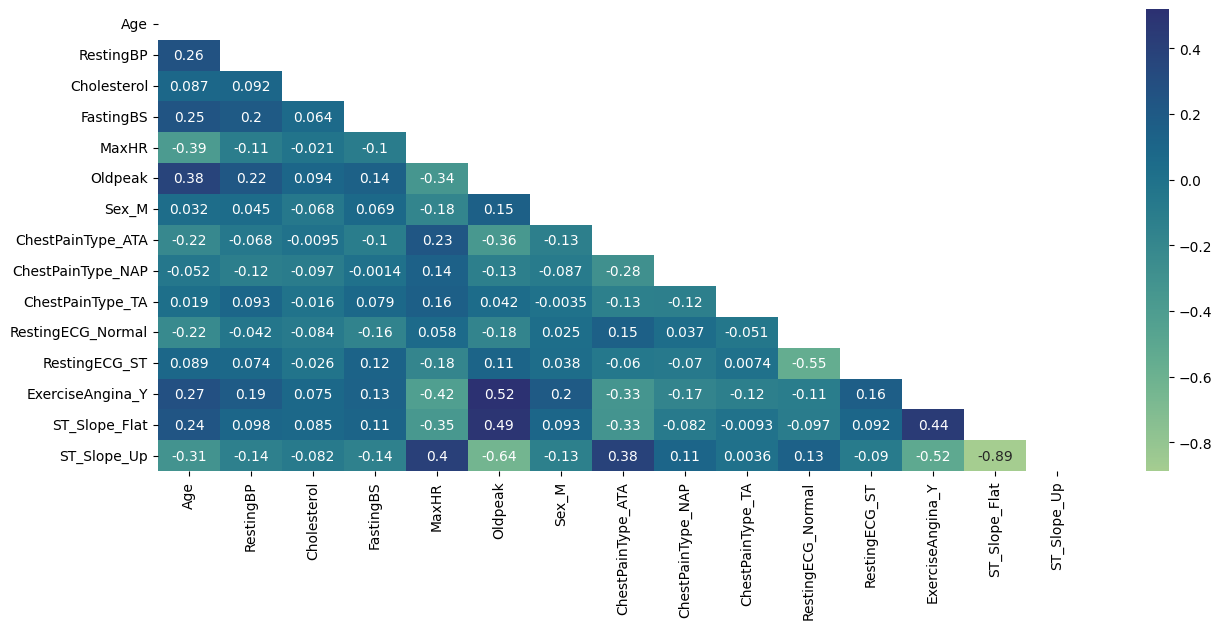

In [26]:
figure_corr_ff_lr, axis_corr_ff_lr = plt.subplots(figsize=(15, 6))

corr_ff_lr = X_train_lr.corr(method='spearman')

mask = np.triu(np.ones_like(corr_ff_lr))
sns.heatmap(corr_ff_lr, annot=True, cmap='crest', mask=mask)

Kada je u pitanju **KNN** ili **model stabla odluke**:

<Axes: >

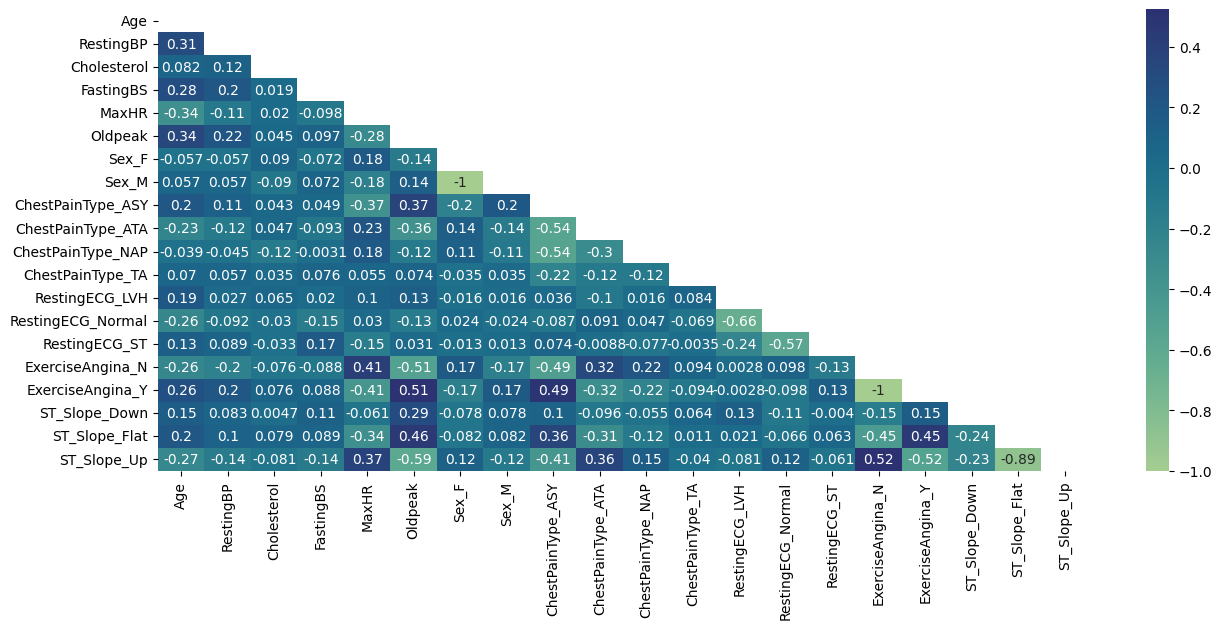

In [27]:
figure_corr_ff_kt, axis_corr_ff_kt = plt.subplots(figsize=(15, 6))

corr_ff_kt = X_train_kt.corr(method='spearman')

mask = np.triu(np.ones_like(corr_ff_kt))
sns.heatmap(corr_ff_kt, annot=True, cmap='crest', mask=mask)

Provjerimo sada koje bi *feature*-e uklonili ako bismo samo posmatrali njihovu međusobnu korelaciju.

Kada je u pitanju **logistička regresija**:

In [28]:
corr_ff_lr = corr_ff_lr.abs()
upp_lr = corr_ff_lr.where(np.triu(np.ones(corr_ff_lr.shape), k=1).astype(bool))
to_drop_ff_lr = [column for column in upp_lr.columns if any(upp_lr[column] >= 0.6)]
to_drop_ff_lr

['ST_Slope_Up']

Kada je u pitanju **KNN** ili **model stabla odluke**:

In [29]:
corr_ff_kt = corr_ff_kt.abs()
upp_kt = corr_ff_kt.where(np.triu(np.ones(corr_ff_kt.shape), k=1).astype(bool))
to_drop_ff_kt = [column for column in upp_kt.columns if any(upp_kt[column] >= 0.6)]
to_drop_ff_kt

['Sex_M', 'RestingECG_Normal', 'ExerciseAngina_Y', 'ST_Slope_Up']

Uzmimo presjek oba svijeta - uklonićemo *feature*-e koji nisu toliko povezani sa *target* kolonom ali su dosta korelirani sa ostalim *feature*-ima.

Kada je u pitanju **logistička regresija**:

In [30]:
to_drop_lr = [drop for drop in to_drop_ft_lr if drop in to_drop_ff_lr]
to_drop_lr

[]

Kada je u pitanju **KNN** ili **model stabla odluke**:

In [31]:
to_drop_kt = [drop for drop in to_drop_ft_kt if drop in to_drop_ff_kt]
to_drop_kt

['RestingECG_Normal']

In [32]:
X_train_lr.drop(labels=to_drop_lr, axis='columns', inplace=True)
X_train_kt.drop(labels=to_drop_kt, axis='columns', inplace=True)

X_test_lr.drop(labels=to_drop_lr, axis='columns', inplace=True)
X_test_kt.drop(labels=to_drop_kt, axis='columns', inplace=True)

Poslednji pogled na podatke.

In [33]:
X_train_lr.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up
680,-0.500000,0.4,0.264706,0,0.444444,-0.333333,True,False,True,False,False,False,False,False,True
724,0.071429,-0.1,-0.500000,0,-0.277778,1.000000,False,False,False,False,False,True,True,True,False
368,1.571429,-1.3,-1.852941,0,-0.555556,2.000000,True,False,True,False,False,False,False,False,False
495,0.642857,0.5,-0.647059,0,1.083333,-0.333333,False,True,False,False,True,False,False,False,True
447,0.785714,-0.5,-0.911765,0,0.000000,-0.066667,True,False,False,False,True,False,False,False,True


In [34]:
X_train_kt.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,Sex_F,Sex_M,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_ST,ExerciseAngina_N,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
689,0.785714,1.25,0.492537,0,0.210526,0.1875,True,False,False,False,True,False,False,False,True,False,False,False,True
28,-0.071429,-0.85,3.462687,0,-0.342105,-0.3125,True,False,False,True,False,False,False,False,True,False,False,False,True
211,0.142857,0.00,0.597015,0,-0.315789,0.3125,False,True,False,False,True,False,False,False,False,True,False,False,True
473,0.857143,1.50,-0.119403,0,-0.052632,1.1250,False,True,True,False,False,False,True,False,True,False,False,False,True
538,0.857143,-0.50,0.985075,0,0.289474,-0.0625,False,True,True,False,False,False,True,False,True,False,False,True,False


Sada smo spremni eksportovati podatke za naš ciljani model. Zasebno eksportujemo testne i trening podatke.

In [35]:
# Logistička regresija
X_train_lr.to_csv('Logistic_Regression/X_train_lr.csv', index=False)
y_train_lr.to_csv('Logistic_Regression/y_train_lr.csv', index=False)
X_test_lr.to_csv('Logistic_Regression/X_test_lr.csv', index=False)
y_test_lr.to_csv('Logistic_Regression/y_test_lr.csv', index=False)

# KNN i model stabla odluke
X_train_kt.to_csv('KNN_DT/X_train_kt.csv', index=False)
y_train_kt.to_csv('KNN_DT/y_train_kt.csv', index=False)
X_test_kt.to_csv('KNN_DT/X_test_kt.csv', index=False)
y_test_kt.to_csv('KNN_DT/y_test_kt.csv', index=False)